## Deep Convolutional GAN with Flickr Face

Deep convolutional generative adversarial neural network (DCGAN) will be applied on complex RGB images. The general concept and GAN model is similiar to Vanilla GAN, just the difference is DCGAN employs convolutional layers instead of fully connected layers. Larger color images will be used to train instead of smaller grayscale images. However, due to the complexity, the training process will take significantly more time.

In [58]:
# import libraries
import os
import time
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [59]:
# initialize variables
device: torch.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epoch_number: int = 30
latent_dimension: int = 128
batch_size: int = 16
discriminator_learning_rate: float = 0.0002
generator_learning_rate: float = 0.0002
checkpoint_path: str = os.path.join('model_checkpoint', 'dcgan_flickr_faces')
image_height: int = 64
image_width: int = 64
channel_number: int = 3

#### 1. Dataset Setup

In [60]:
transform = v2.Compose([
    v2.Resize((image_height, image_width)),
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

training_dataset = datasets.ImageFolder(
    root = '../../dataset/flickr_faces/',
    transform = transform,
)

training_dataloader = DataLoader(
    dataset = training_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 1
)

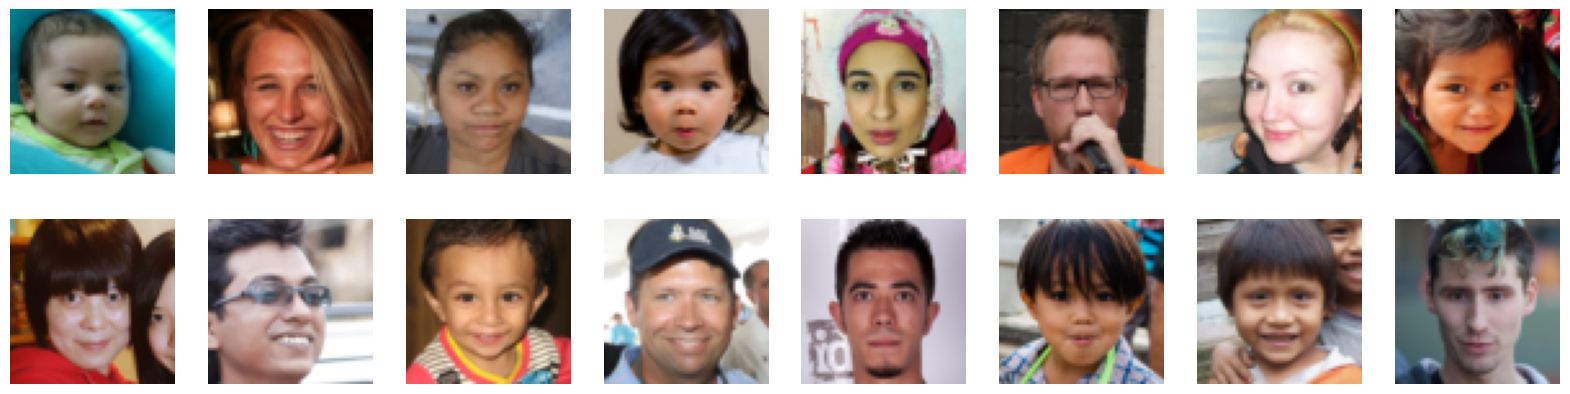

In [61]:
# visualization
plt.figure(figsize = (20, 5))

for image in range(batch_size):
    nbr_row = 2
    nbr_col = 8

    for i in range(nbr_row * nbr_col):
        image = training_dataset[i][0] / 2 + 0.5 
        ax = plt.subplot(nbr_row, nbr_col, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.axis("off")

#### 2. Network Architecture Creation

In [62]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(
                self.latent_dim, 1024, kernel_size = 4,
                stride = 4, padding = 1 
            ),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                1024, 512, kernel_size = 4,
                stride = 2, padding = 1 
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                512, 256, kernel_size = 4,
                stride = 2, padding = 1 
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size = 4,
                stride = 2, padding = 1 
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size = 4,
                stride = 2, padding = 1 
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 3, kernel_size = 4,
                stride = 2, padding = 1 
            ),
            nn.Tanh()
        )

    def forward(self, input):
        return self.generator(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size = 4,
                stride = 2, padding = 1
            ),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                64, 128, kernel_size = 4,
                stride = 2, padding = 1
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                128, 256, kernel_size = 4,
                stride = 2, padding = 1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                256, 512, kernel_size = 4,
                stride = 2, padding = 1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                512, 1024, kernel_size = 4,
                stride = 2, padding = 1
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                1024, 1, kernel_size = 3,
                stride = 4, padding = 1
            )
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # get batch size
        bs, _, _, _ = x.shape
        # reduce the spatial dimensions (height and width) of the input tensor x to 1 x 1
        # reshape to (batch size, x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.linear_layers(x)
        return x

In [63]:
generator = Generator(latent_dimension).to(device)
print(generator)

total_params = sum(p.numel() for p in generator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in generator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [64]:
discriminator = Discriminator().to(device)
print(discriminator)

total_params = sum(p.numel() for p in discriminator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Discriminator(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv

#### 3. Model Training

In [65]:
# define loss functions
bce = nn.BCELoss()

def loss_func(y_true, y_pred):
    loss = bce(y_pred, y_true)
    return loss

In [66]:
# define optimizer
# adam optimizer will be applied as it is known to work well for many applications
optimizer_generator = optim.Adam(
    generator.parameters(), 
    lr = generator_learning_rate,
    betas = (0.5, 0.999)
)

optimizer_discriminator = optim.Adam(
    discriminator.parameters(), 
    lr = discriminator_learning_rate,
    betas = (0.5, 0.999)
)

In [67]:
# generate check point directory
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

num_versions = len(os.listdir(checkpoint_path)) + 1
ckpt_version_dir = checkpoint_path + '/version_' + str(num_versions)

os.makedirs(ckpt_version_dir)

# check point naming
generator_ckpt = os.path.join(ckpt_version_dir, 'generator' + '.pth')
discriminatr_ckpt = os.path.join(ckpt_version_dir, 'discriminator' + '.pth')

In [68]:
generator_loss = []
discriminator_loss = []

for epoch in range(epoch_number):
    generator.train()
    discriminator.train()

    start = time.time()
    discriminator_loss_list, generator_loss_list = [], []

    for idx, data in tqdm(enumerate(training_dataloader), total = int(len(training_dataloader))):
        image_batch, label = data
        image_batch = image_batch.to(device)

        optimizer_generator.zero_grad()
        optimizer_discriminator.zero_grad()

        # create labels for real and fake data
        # 1 for real data and 0 for fake data
        gt_labels = torch.cat((
            torch.ones(batch_size, 1),
            torch.zeros(batch_size, 1)
        ), dim = 0).to(device)

        misleading_labels = torch.ones(
            batch_size, 1
        ).to(device)

        noise = torch.randn(
            batch_size, latent_dimension, 1, 1
        ).to(device)

        # start training discriminator
        fake_images = generator(noise)
        y_pred_real = discriminator(image_batch)
        y_pred_fake = discriminator(fake_images)

        y_pred_discriminator = torch.cat((
            y_pred_real, y_pred_fake
        ), dim = 0)

        discriminator_loss_batch = loss_func(gt_labels, y_pred_discriminator)

        discriminator_loss_batch.backward()
        optimizer_discriminator.step()

        # start training generator
        fake_images = generator(noise)
        y_pred_fake = discriminator(fake_images)
        generator_loss_batch = loss_func(misleading_labels, y_pred_fake)

        generator_loss_batch.backward()
        optimizer_generator.step()

        discriminator_loss_list.append(discriminator_loss_batch)
        generator_loss_list.append(generator_loss_batch)

        break

    if (epoch + 1) % 5 == 0:
        torch.save(generator, generator_ckpt)
        torch.save(discriminator, discriminatr_ckpt)

    epoch_discriminator_loss = sum(discriminator_loss_list) / len(discriminator_loss_list)
    epoch_generator_loss = sum(generator_loss_list) / len(generator_loss_list)

    discriminator_loss.append(epoch_discriminator_loss.detach().cpu())
    generator_loss.append(epoch_generator_loss.detach().cpu())

    break

  0%|          | 0/4375 [00:00<?, ?it/s]


In [53]:
def training_step(real_image):
    optimizer_generator.zero_grad()
    optimizer_discriminator.zero_grad()

    label = torch.cat((
        torch.ones(batch_size, 1),
        torch.zeros(batch_size, 1)
    ), dim = 0).to(device)

    misleading_label = torch.ones(
        batch_size, 1
    ).to(device)

    noise = torch.randn(
        batch_size, 
        latent_dimension,
        1, 1
    ).to(device)

    fake_image = generator(noise)
    y_pred_real = discriminator(real_image)
    y_pred_fake = discriminator(fake_image)

    y_pred_D = torch.cat((
        y_pred_real, y_pred_fake
    ), dim = 0)

    discriminator_loss = loss_func(label, y_pred_D)
        
    discriminator_loss.backward()
    optimizer_discriminator.step()

    fake_image = generator(noise)

    y_pred_fake = discriminator(fake_image)

    generator_loss = loss_func(misleading_label, y_pred_fake)

    generator_loss.backward()
    optimizer_generator.step()

    return discriminator_loss, generator_loss

In [16]:
fixed_noise = torch.randn(
    batch_size, 
    latnet_dimension,
    1, 1
)

In [17]:
def plot_image(model):
    model.eval()

    with torch.no_grad():
        images = model(fixed_noise.to(device))
        images = images.detach().cpu()

    plt.figure(figsize = (20, 4))

    nrow = 2
    ncol = int(images.shape[0] / nrow)
    
    for i, image in enumerate(images):
        col = int(batch_size / 2)
        plt.subplot(nrow, ncol, i + 1)
        image = (image.permute(1, 2, 0).squeeze(0) + 1) * 127.5
        plt.imshow(np.array(image).astype('uint8'))
        plt.axis('off')
        
    plt.show()

In [18]:
plot_generator_loss = []
plot_discriminator_loss = []

def training(dataloader, epochs):
    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        start = time.time()
        i = 0
        discriminator_loss_list, generator_loss_list = [], []
        
        for bi, data in tqdm(enumerate(dataloader), total=int(len(dataloader))):
            image_batch, _ = data
            image_batch = image_batch.to(device)
            
            i += 1
            
            discriminator_loss, generator_loss = training_step(image_batch)
            
            discriminator_loss_list.append(discriminator_loss)
            generator_loss_list.append(generator_loss)
            
        if (epoch + 1) % 5 == 0:
            torch.save(generator, generator_ckpt)
            torch.save(discriminator, discriminatr_ckpt)
            
        epoch_discriminator_loss = sum(discriminator_loss_list) / len(discriminator_loss_list)
        epoch_generator_loss = sum(generator_loss_list) / len(generator_loss_list)

        plot_discriminator_loss.append(epoch_discriminator_loss.detach().cpu())
        plot_generator_loss.append(epoch_generator_loss.detach().cpu())
        
        print('\n')
        print(f"Time for epoch {epoch + 1} is {time.time()-start} sec")
        print(f"Generator loss: {epoch_generator_loss:.3f}, Discriminator loss: {epoch_discriminator_loss:.3f}")

        plot_image(generator)     

100%|██████████| 4375/4375 [03:53<00:00, 18.77it/s]




Time for epoch 1 is 241.49939894676208 sec
Generator loss: 4.912, Discriminator loss: 0.317


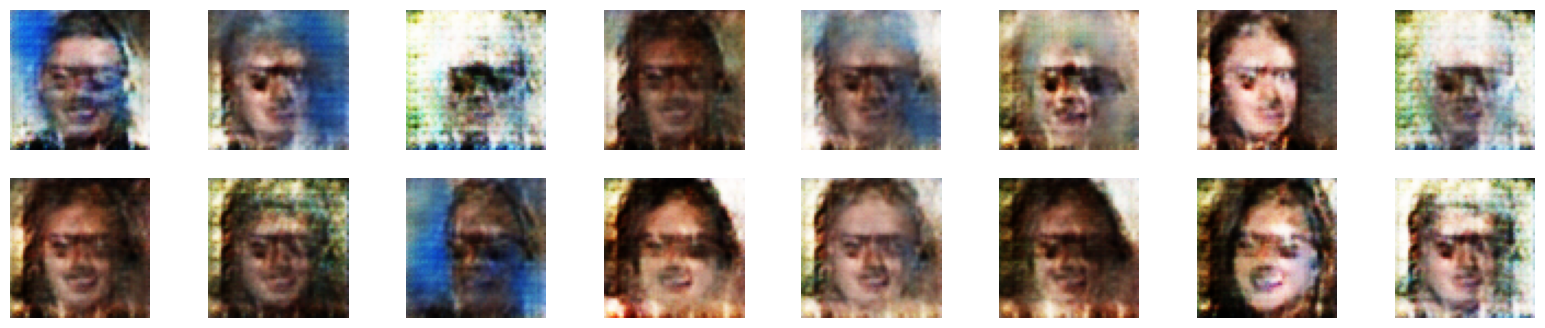

100%|██████████| 4375/4375 [03:53<00:00, 18.74it/s]




Time for epoch 2 is 242.16593480110168 sec
Generator loss: 6.040, Discriminator loss: 0.242


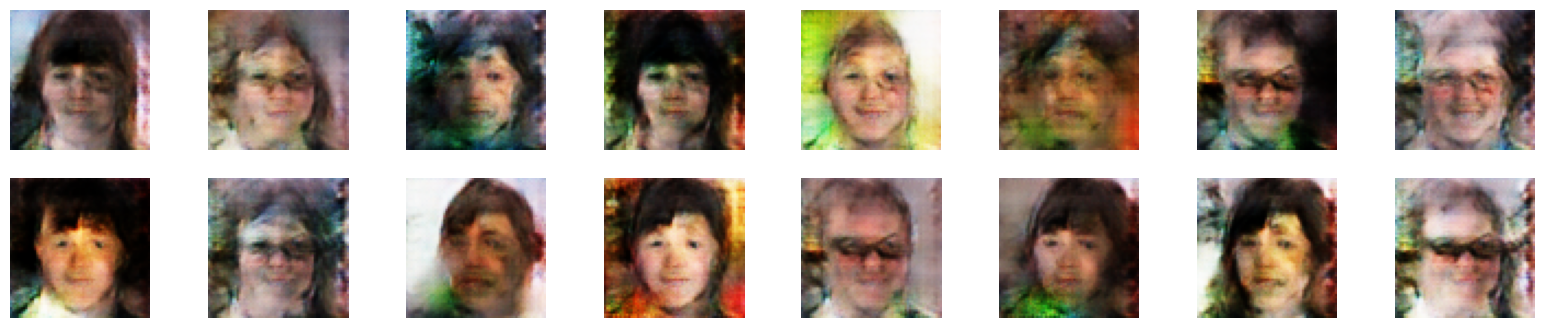

100%|██████████| 4375/4375 [03:53<00:00, 18.78it/s]




Time for epoch 3 is 242.0403208732605 sec
Generator loss: 6.548, Discriminator loss: 0.185


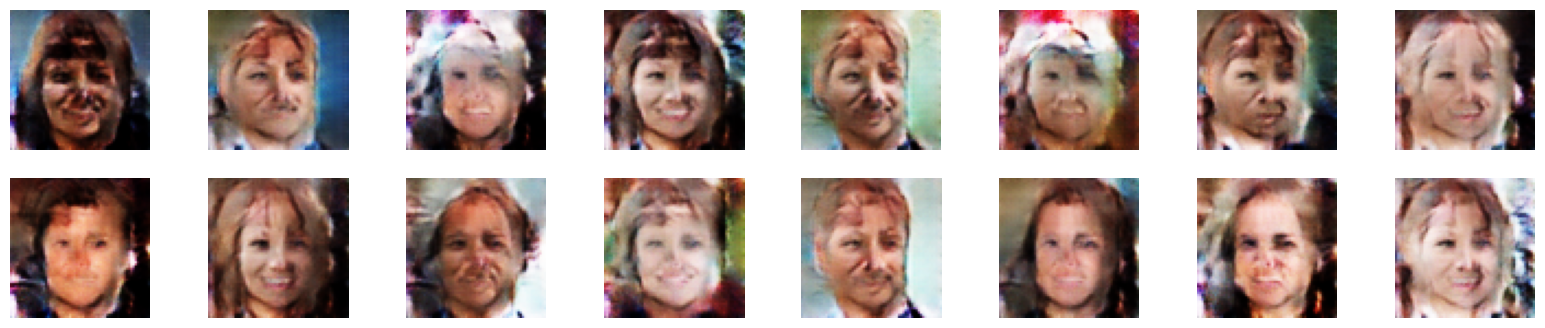

100%|██████████| 4375/4375 [04:26<00:00, 16.44it/s]




Time for epoch 4 is 275.3672640323639 sec
Generator loss: 7.011, Discriminator loss: 0.152


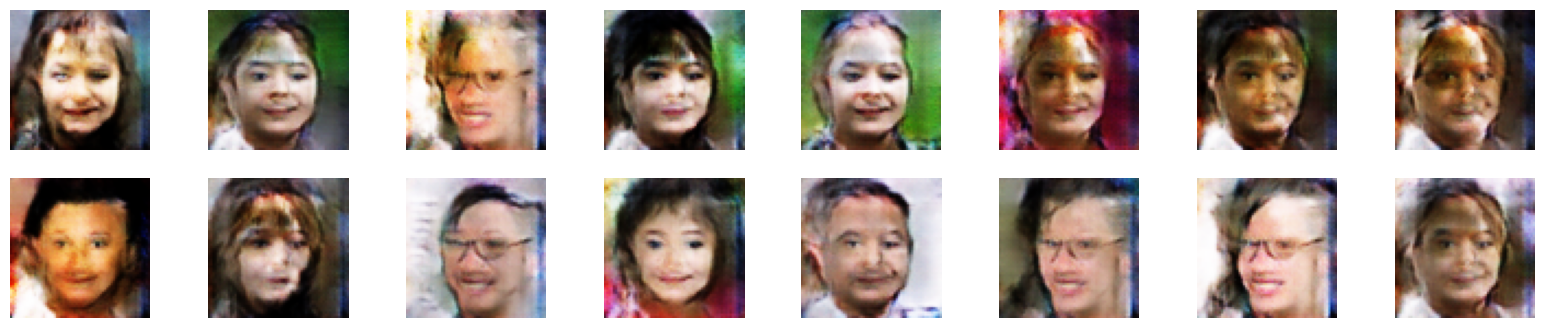

100%|██████████| 4375/4375 [03:52<00:00, 18.85it/s]




Time for epoch 5 is 241.22236347198486 sec
Generator loss: 6.928, Discriminator loss: 0.150


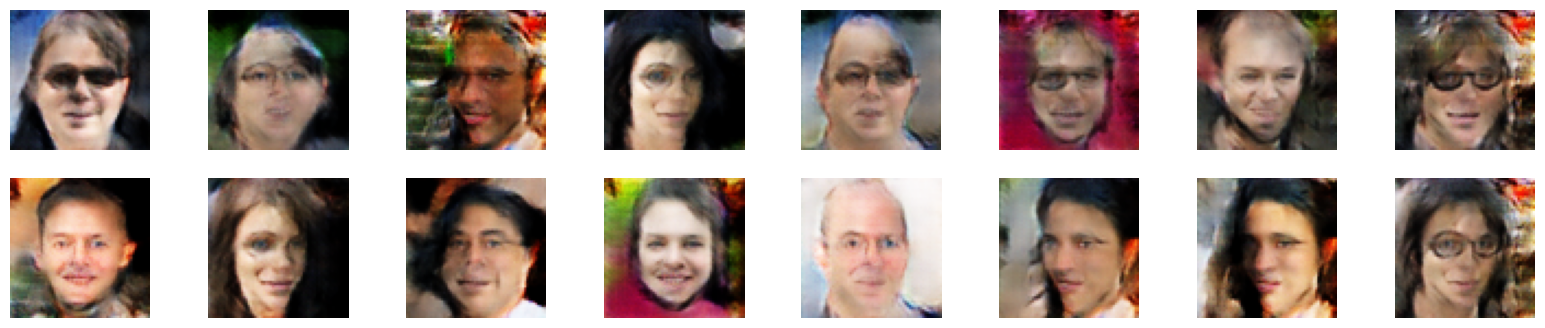

100%|██████████| 4375/4375 [03:52<00:00, 18.84it/s]




Time for epoch 6 is 241.165452003479 sec
Generator loss: 7.032, Discriminator loss: 0.136


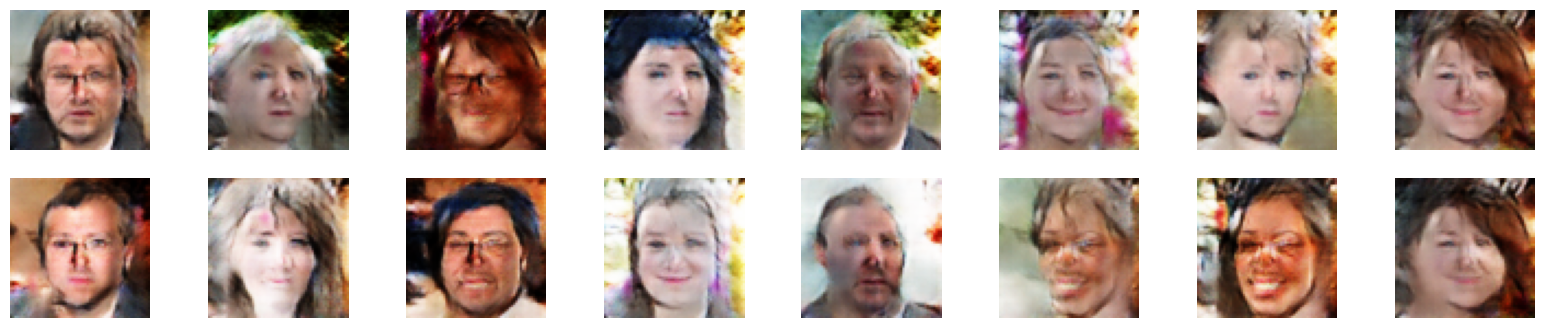

100%|██████████| 4375/4375 [03:52<00:00, 18.83it/s]




Time for epoch 7 is 241.4623658657074 sec
Generator loss: 6.865, Discriminator loss: 0.141


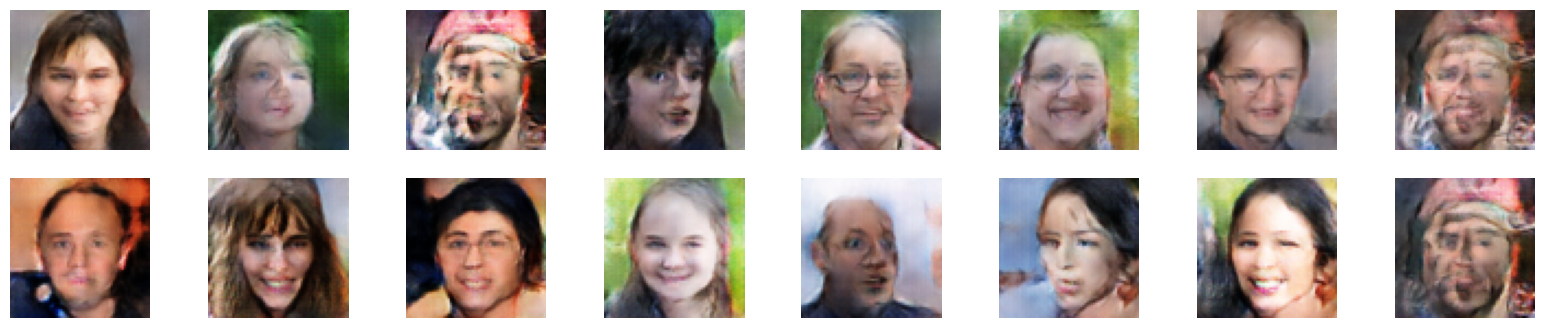

100%|██████████| 4375/4375 [03:53<00:00, 18.76it/s]




Time for epoch 8 is 242.45054268836975 sec
Generator loss: 6.872, Discriminator loss: 0.132


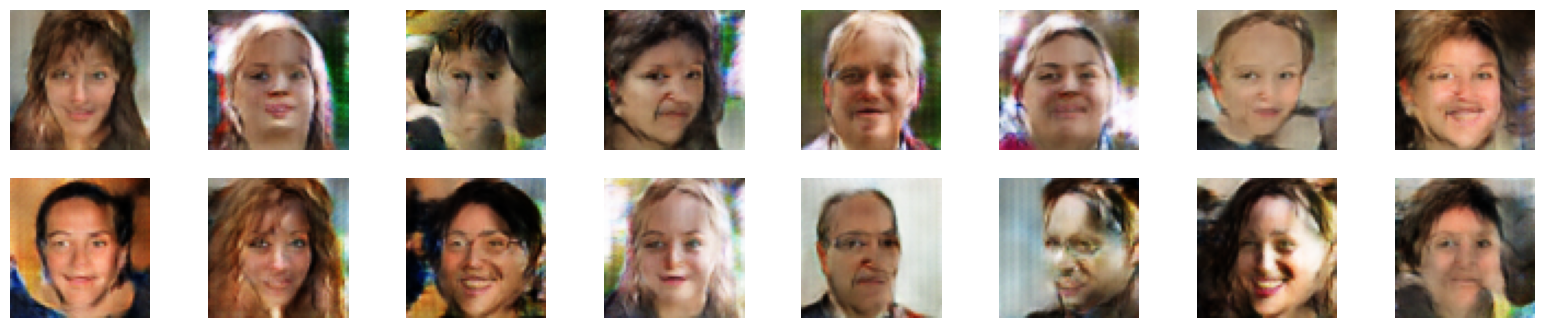

100%|██████████| 4375/4375 [03:52<00:00, 18.80it/s]




Time for epoch 9 is 241.6218819618225 sec
Generator loss: 6.957, Discriminator loss: 0.127


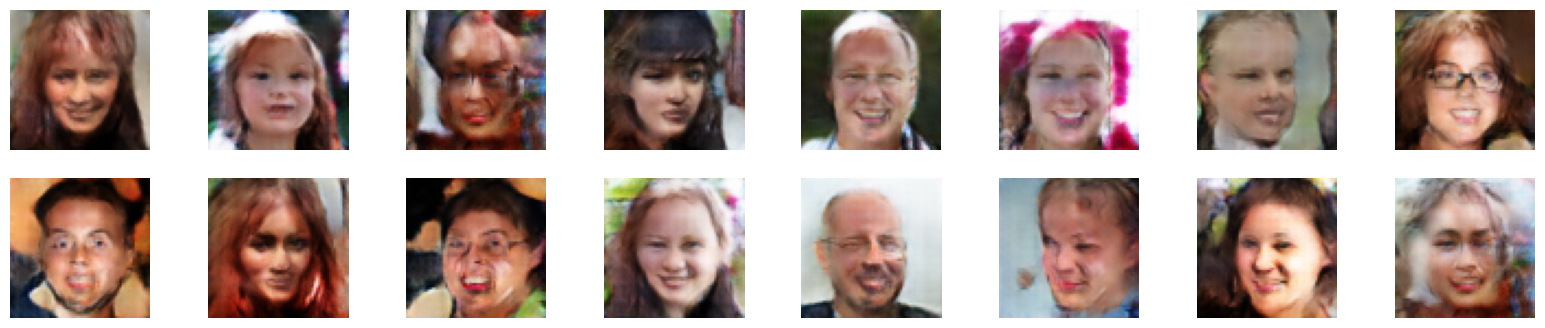

100%|██████████| 4375/4375 [03:53<00:00, 18.77it/s]




Time for epoch 10 is 243.02569603919983 sec
Generator loss: 6.820, Discriminator loss: 0.130


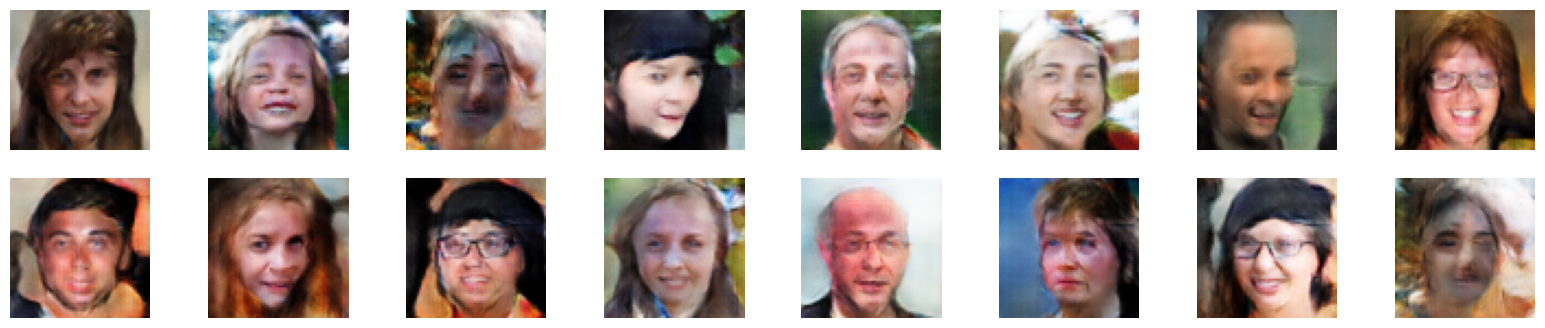

In [19]:
training(train_dataloader, 10)

In [21]:
def plot_result(metrics, ylabel = None, ylim = None, metric_name = None, color = None):
    
    fig, ax = plt.subplots(figsize = (18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
    
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color = color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, epoch_number - 1])
    plt.ylim(ylim)

    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block = False)

NameError: name 'MultipleLocator' is not defined

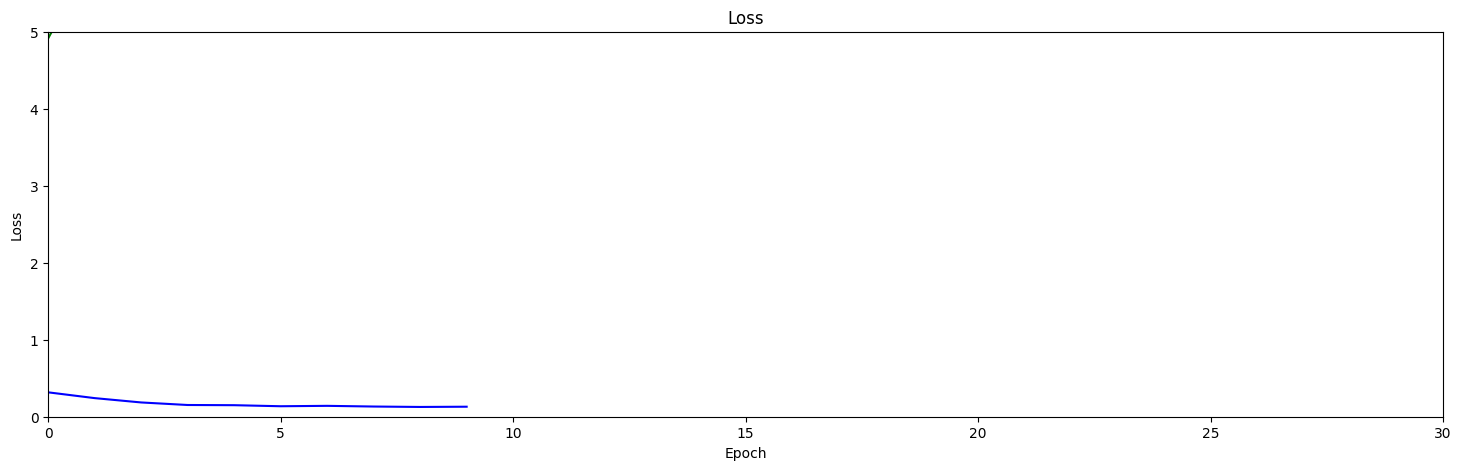

In [22]:
plot_result([plot_generator_loss, plot_discriminator_loss],        
    ylabel = "Loss", 
    ylim = [0, 5],
    metric_name = ["Generator Loss", "Discriminator Loss"],
    color = ["g", "b"])

In [23]:
generator = Generator(latnet_dimension)

trained_generator = torch.load(generator_ckpt)

print(trained_generator)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [24]:
def generate_image(model, noise):
    
    model.eval()
    with torch.no_grad():
        images = model(noise.to(device))
        images = images.detach().cpu()

    plt.figure(figsize = (20, 4))

    nrow = 2
    ncol = int(images.shape[0] / nrow)
    
    for i, image in enumerate(images):
        col = int(batch_size / 2)
        plt.subplot(nrow, ncol, i + 1)
        image = (image.permute(1, 2, 0).squeeze(0) + 1) * 127.5
        plt.imshow(np.array(image).astype('uint8'))
        plt.axis('off')
        
    plt.show()

In [25]:
noise = torch.randn(
    batch_size, 
    latnet_dimension,
    1, 1
).to(device)

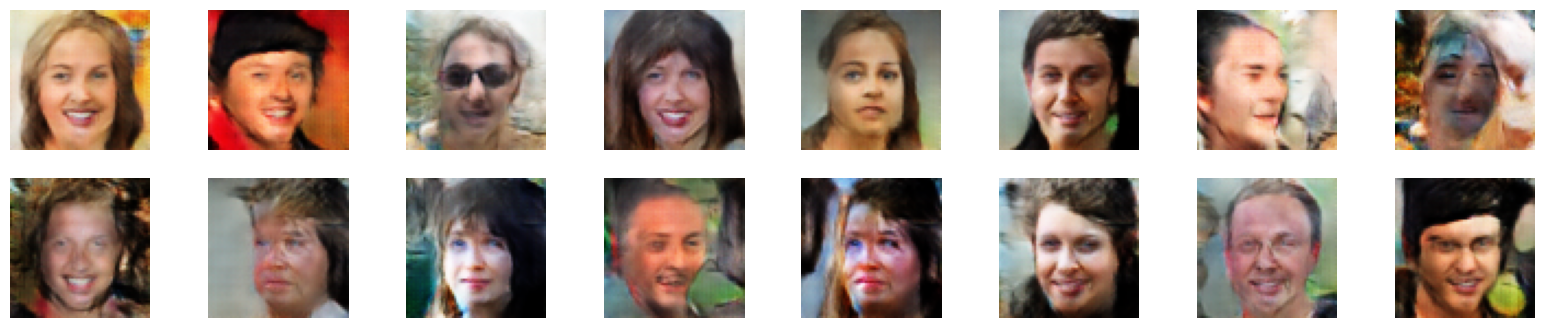

In [26]:
generate_image(trained_generator, noise)